In [11]:
import h5pyd
from pyproj import Proj

import pandas as pd
import numpy as np

wt_df = pd.read_csv('uswtdbCSV/uswtdb_v1_2_20181001.csv')

# Grabbed from the intro demo notebook at https://www.nrel.gov/grid/wind-toolkit.html
f = h5pyd.File("/nrel/wtk-us.h5", 'r') 

dset_coords = f['coordinates']
projstring = """+proj=lcc +lat_1=30 +lat_2=60 
                    +lat_0=38.47240422490422 +lon_0=-96.0 
                    +x_0=0 +y_0=0 +ellps=sphere 
                    +units=m +no_defs """
projectLcc = Proj(projstring)
origin_ll = reversed(dset_coords[0][0])  # Grab origin directly from database
origin = projectLcc(*origin_ll)

def updatedIndicesForCoord(f, origin, projectLcc, lat, lon):
    coords = (lon, lat)
    coords = projectLcc(*coords)
    delta = np.subtract(coords, origin)
    ij = [int(round(x/2000)) for x in delta]
    return tuple(reversed(ij))

_xy = wt_df[['ylat','xlong']].apply(lambda x: updatedIndicesForCoord(f, origin, projectLcc, *x), axis=1)
wt_df['coord_idx'] = _xy

In [13]:
turbines_97_103 = wt_df[(wt_df['t_hh'] > 97) & (wt_df['t_hh'] < 103)]
coordinates_97_103 = turbines_97_103['coord_idx'].unique()

turbines_55_65 = wt_df[(wt_df['t_hh'] > 55) & (wt_df['t_hh'] < 65)]
coordinates_55_65 = turbines_55_65['coord_idx'].unique()

In [21]:
winddirection_200_dataset = f['winddirection_200m']
winddirection_160_dataset = f['winddirection_160m']
winddirection_100_dataset = f['winddirection_100m']
winddirection_60_dataset = f['winddirection_60m']

In [15]:
def getDataForCoordinates(coords, dataset):
    speed = []
    
    i = 0
    for coordinate in coords:
        if (i % 100 == 0):
            print(i)
        i += 1
        speed.append(dataset[0:8928, coordinate[0], coordinate[1]])
        
    return speed
        
winddirection_100 = getDataForCoordinates(coordinates_97_103, winddirection_100_dataset)
winddirection_60 = getDataForCoordinates(coordinates_55_65, winddirection_60_dataset)
winddirection_100_for_60_turbine = getDataForCoordinates(coordinates_55_65, winddirection_100_dataset)
winddirection_160_for_60_turbine = getDataForCoordinates(coordinates_55_65, winddirection_160_dataset)
winddirection_200_for_60_turbine = getDataForCoordinates(coordinates_55_65, winddirection_200_dataset)

0
100
200
300
400
0
100
0
100


In [22]:
winddirection_160_for_60_turbine = getDataForCoordinates(coordinates_55_65, winddirection_160_dataset)
winddirection_200_for_60_turbine = getDataForCoordinates(coordinates_55_65, winddirection_200_dataset)

0
100
0
100


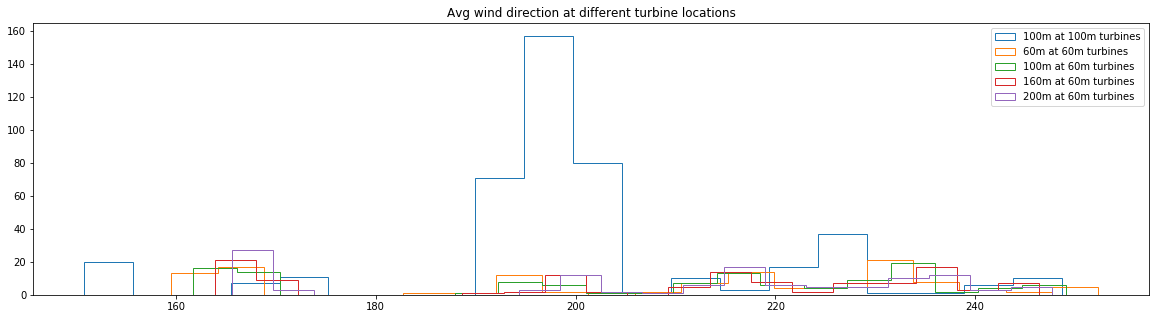

In [43]:
winddirection_60_avg = np.apply_along_axis(np.mean, 1, winddirection_60)
winddirection_100_for_60_avg = np.apply_along_axis(np.mean, 1, winddirection_100_for_60_turbine)
winddirection_160_for_60_avg = np.apply_along_axis(np.mean, 1, winddirection_160_for_60_turbine)
winddirection_200_for_60_avg = np.apply_along_axis(np.mean, 1, winddirection_200_for_60_turbine)
winddirection_100_avg = np.apply_along_axis(np.mean, 1, winddirection_100)

plt.figure(figsize=(20, 5))

plt.hist(winddirection_100_avg, bins=20, histtype='step', label='100m at 100m turbines')

plt.hist(winddirection_60_avg, bins=20, histtype='step', label='60m at 60m turbines')
plt.hist(winddirection_100_for_60_avg, bins=20, histtype='step', label='100m at 60m turbines')
plt.hist(winddirection_160_for_60_avg, bins=20, histtype='step', label='160m at 60m turbines')
plt.hist(winddirection_200_for_60_avg, bins=20, histtype='step', label='200m at 60m turbines')

plt.title('Avg wind direction at different turbine locations')
plt.legend()

plt.show()